In [105]:
%load_ext autoreload
%autoreload 2
from helpers import *
import statsmodels.api as sm
import pickle
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

data_folder = './DATA/'
plot_folder = './plots/'

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Table of Contents
1. [Gender Proportions](#section-1)
2. [Age](#section-2)
3. [Main Characters' Genders](#section-3)
4. [Clustering](#section-4)
    4.1. [Creating Clustering Data](#subsection-4.1)
    4.2. [K-means clustering](#subsection-4.2)
   4.3. [Analysis of the clusters](#subsection-4.3)

In [106]:
# load the data
timeline = pd.read_csv(data_folder + 'timeline.csv')
movie_data = pickle.load(open("DATA/movie_data_final.pickle", "rb"))
character_data = pd.read_pickle(data_folder+'final.pickle')
#adding the decade for analyses (this should also be moved in the data construction)
character_data['decade'] = ((character_data['release_date'].astype(int))//10)*10

# 1) Gender Proportions
<a id='section-1'></a>

#### Proportion analysis
**What's the proportion of female actors in movies per year?**
We wonder if the proportion of female actors' increase over the years, which is what we would expect.

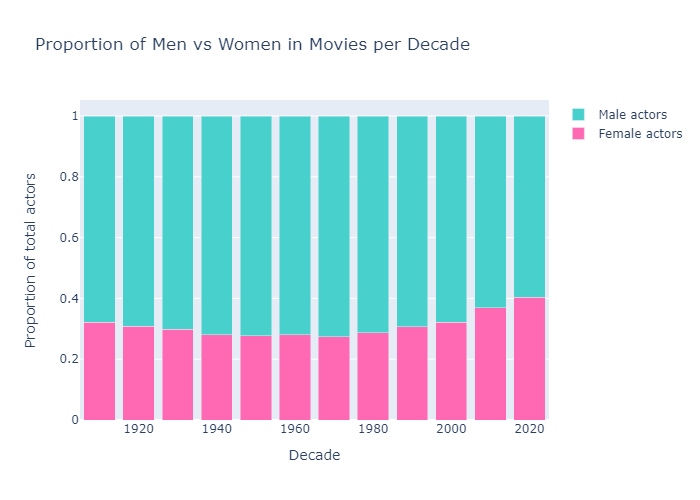

In [107]:
plot_proportion_men_women_per_decade(character_data, folder=plot_folder, file_name='proportion_men_women.html')

Interestingly, the proportion of women over the decades stayed fairly constant, graphically, between 30% and 40%. This contrasts with what we expected as we would think that women representation would get better over the years. Nonetheless, it seems that the proportion of female actors has started to slowly but steadily increase since the 70s. In order to look at this increase we are going to fit a regression line starting in 1970 to model this rise. This will also allow us to estimate when, according to this trend-line, the parity will be reached.

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 6 samples were given.



                            OLS Regression Results                            
Dep. Variable:             proportion   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     66.81
Date:                Wed, 20 Dec 2023   Prob (F-statistic):            0.00122
Time:                        12:05:02   Log-Likelihood:                 18.612
No. Observations:                   6   AIC:                            -33.22
Df Residuals:                       4   BIC:                            -33.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8660      0.635     -7.658      0.0

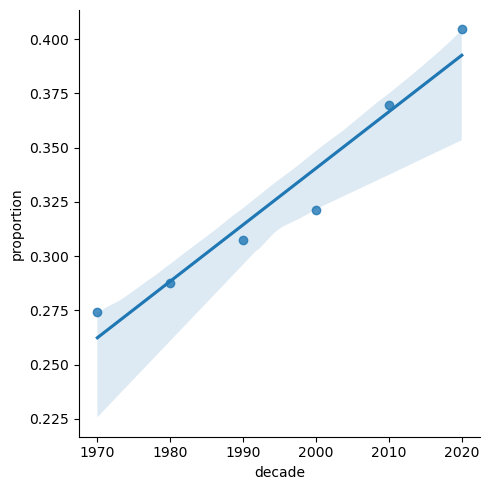

In [108]:
final_characters_grouped_by_decade = character_data.groupby(['decade'])

proportion_female = final_characters_grouped_by_decade['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))

proportions_female_per_decade = pd.DataFrame()
proportions_female_per_decade['decade'] = proportion_female.index
proportions_female_per_decade['proportion'] = proportion_female.values

proportion_female_after1970 = proportions_female_per_decade[proportions_female_per_decade['decade']>=1970]
sns.lmplot(proportion_female_after1970, x='decade', y='proportion')

# Fit the linear model using statsmodels
X = sm.add_constant(proportion_female_after1970['decade'])
y = proportion_female_after1970['proportion']
model = sm.OLS(y, X).fit()

# Print the summary of the linear model
print(model.summary())

# Show the plot
plt.show()

We see that starting in 1970 there is a small but significant increase (p-value:0.001 and $R^2$: 0.944) per decade: per decade there is a 0.026 increase (0.0026 per year). We decided to only start this regression in 1970 as before that the proportion of women was actually decreasing (see scatter plot) before that, but we’re only interested in the upward trend we have been seeing for the past 50 years. From this it is interesting to predict, when, according to this regression 50-50 representation would occur. We know the intercept (-4.8660) and the slope (0.0026 per year). To find when the 0.5 proportion will be reached we simply need to solve the equation 0.5 = 0.0026x - 4.8660.

In [109]:
x_fifty_fifty = (0.5+4.8660)/0.0026
x_fifty_fifty

2063.846153846154

We see that fifty-fifty men and women representation should theoretically be reached in 2064. One limitation of our analysis, is that of course if we follow the trend-line there would be a point in which there would be a 100% of women representation which is not very realistic in Hollywood.

Now that the regression confirmed that there was indeed an increase in women representation from the 70s, we can see if this increase could be linked to historical events in our timeline.

In [110]:
for idx in timeline[(timeline['Date']>=1960)&(timeline['Date']<1970)].index:
    print(f'{timeline.Date[idx]} : {timeline.Event[idx]}')

1960 : The Food and Drug Administration (FDA) approves the first commercially produced birth control pill in the world, allowing women to control when and if they have children. Margaret Sanger initially commissioned “the pill” with funding from heiress Katherine McCormick.
1963 :  President John F. Kennedy signs into law the Equal Pay Act, prohibiting sex-based wage discrimination between men and women performing the same job in the same workplace.
1964 :  President Lyndon B. Johnson, signs the Civil Rights Act into law; Title VII bans employment discrimination based on race, religion, national origin or sex.
1966 :  Betty Friedan, author of 1963’s The Feminine Mystique, helps found the National Organization for Women (NOW), using, as the organization now states, “grassroots activism to promote feminist ideals, lead societal change, eliminate discrimination, and achieve and protect the equal rights of all women and girls in all aspects of social, political, and economic life.”


Here we observe that two major events for women's right in the US happened in the 60s: the Equal Pay Act and the Civil Rights Act. The Equal Pay Act prohibits a difference of salary based on sex while the Civil Rights Act prohibits (amongst others) employment discrimination based on sex. These two events were a huge step towards gender equality and they might have a prompted a change in mentality which could result in the proportion of women in movies increasing.

Nevertheless, this result doesn't mean that each movie has approximately 30-40% of women in their actors cast. This result might be biased by movies that have an extremely low/high proportion of women versus movies that have a balanced actors cast. To determine if that is the case, let's plot the proportion of movies per year that have 0-25% actresses, 25-50%, 50-75% or 75-100% actresses. Are female actors represented equally in every movies or is there a discrepency between movies released in the same year?

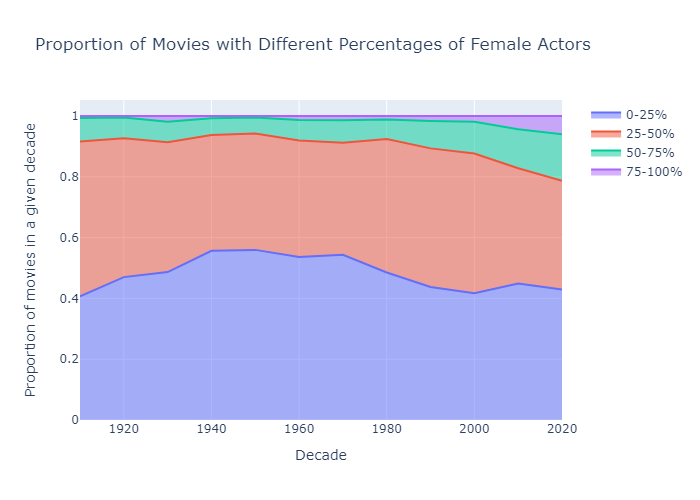

In [111]:
plot_proportion_movies_different_percentages_women(character_data, folder=plot_folder, file_name='movie_proportions.html')

We can observe that a vast majority of movies have less than 50% of women actresses in their cast. Actually, over the years, a vast majority of movies (graphically, approximately 85%) have less than 50% female actors in their cast. Thus, even though overall the proportion of women seems to be close to 30-40% over the years, they are largely underrepresented in the vast majority of movies.
However, it might be interesting to note that from 2000 onwards there are more movies with a majority of women actors in their cast, mirroring the trend of the overall increase in women's proportion in movies

# 2) Age
<a id='section-2'></a>
**What's the age difference of female actors in movies compared to male actors over the years? Are female actors significantly younger than male actors?**

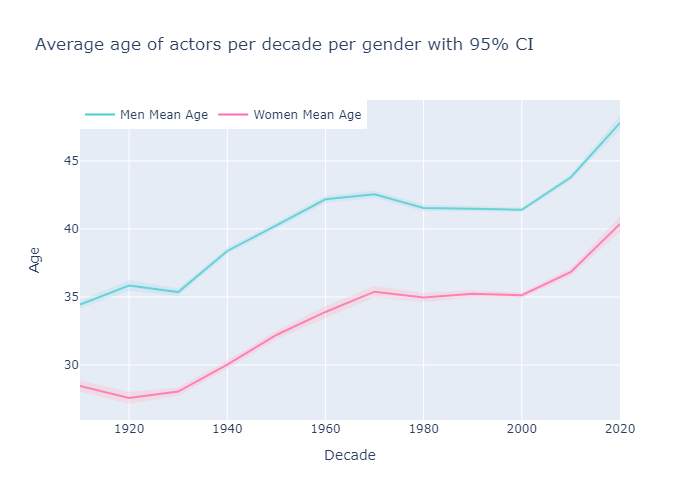

In [112]:
plot_average_age_actor_across_decades(character_data, folder=plot_folder, file_name='Average_age_actor.html')

Between decades 1910 and 2020, female actors are **significantly** younger than men at the 5% significance level. We can see that the average age of actors increase over time (both for men and women). This might be because of the long career span of actors as they usually play in several movies over the year. Thus, the actors in the 80s might be the same as the ones in the 60s, explaining why the average age of actors increases over time. In order to prove that the age difference is significantly different let's perform a 2-sided independent t-test

In [113]:
# Perform a t-test for each decade
# drop the actors with NaN as age
character_age = character_data.dropna(subset=['actor_age']).copy()
# remove actors with a negative age
character_age = character_age[character_age['actor_age'] >= 0]
for decade, group in character_age.groupby(['decade']):
    men = group[group['actor_gender'] == 'M']
    women = group[group['actor_gender'] == 'F']

    # Perform a t-test assuming equal variances
    t_statistic, p_value, df = sm.stats.ttest_ind(men['actor_age'], women['actor_age'])

    # Print the results
    print(f'Decade: {decade}')
    print(f'T-Statistic: {t_statistic}')
    print(f'P-Value: {p_value}')

    # Check significance level
    if p_value < 0.05:
        print('Statistically significant difference\n')
    else:
        print('No statistically significant difference\n')

Decade: (1910,)
T-Statistic: 23.937861450862954
P-Value: 6.689216236239643e-123
Statistically significant difference

Decade: (1920,)
T-Statistic: 25.106201780079132
P-Value: 1.1566776606661776e-133
Statistically significant difference

Decade: (1930,)
T-Statistic: 31.54907147808617
P-Value: 1.2848106654312748e-210
Statistically significant difference

Decade: (1940,)
T-Statistic: 39.800239903459946
P-Value: 0.0
Statistically significant difference

Decade: (1950,)
T-Statistic: 39.05407924583143
P-Value: 0.0
Statistically significant difference

Decade: (1960,)
T-Statistic: 31.379264192755887
P-Value: 1.2900182960965503e-206
Statistically significant difference

Decade: (1970,)
T-Statistic: 27.45803370632024
P-Value: 2.5058439602003275e-161
Statistically significant difference

Decade: (1980,)
T-Statistic: 30.066393039129252
P-Value: 2.1645515886564586e-194
Statistically significant difference

Decade: (1990,)
T-Statistic: 37.00481366332627
P-Value: 6.796412605916962e-294
Statistically

As we can see for every decade the difference is very statistically significant, meaning we can say there is a difference between the mean age of men and women (reject the null that the mean ages are the same)

We also made an interactive plot using plotly to show the histograms of age distributions over time of men and women

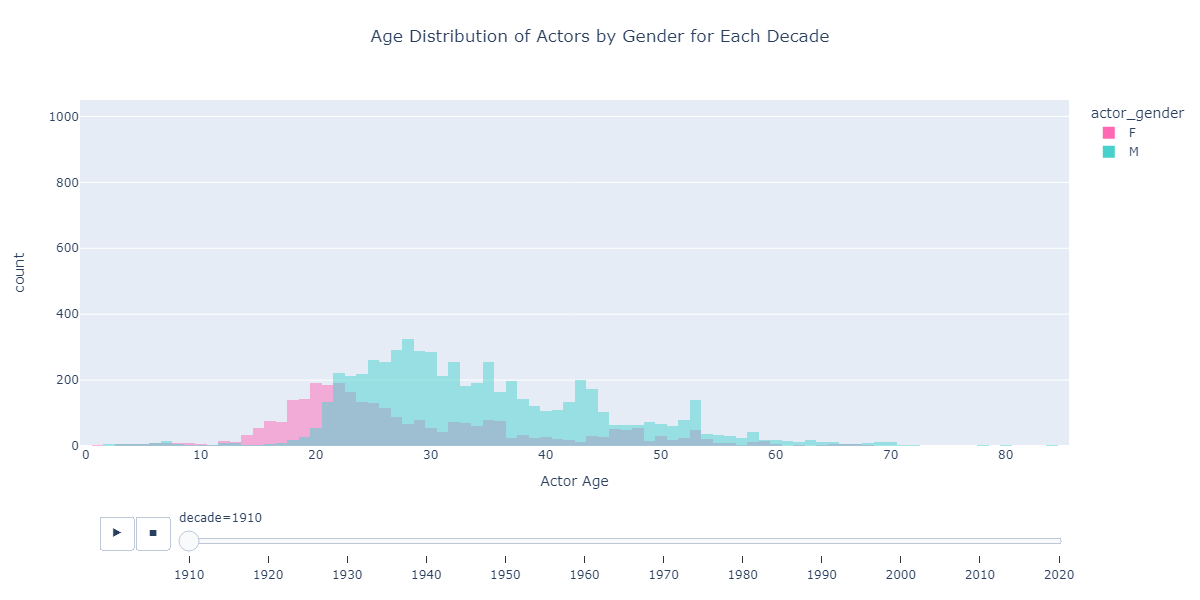

In [114]:
# Sort unique decades
decade_order = sorted(character_age['decade'].unique())

# Define a fixed y-axis range
fixed_yaxis_range = [0, 1050]

# Create the histogram using Plotly Express with a slider for decades
fig = px.histogram(
    character_age,
    x="actor_age",
    color="actor_gender",
    animation_frame="decade",
    labels={"actor_age": "Actor Age"},
    title="Age Distribution of Actors by Gender for Each Decade",
    width=1200,
    height=600,
    barmode="overlay",
    histfunc="count",
    category_orders={"decade": decade_order},
    color_discrete_map = {'M': 'mediumturquoise', 'F': 'hotpink'}
)

# Update layout for better visibility and set fixed y-axis range
fig.update_layout(
    title_x=0.5,
    title_y=0.95,
)

# Set fixed y-axis range for all subplots
for i in range(1, len(decade_order) + 1):
    fig.update_yaxes(range=fixed_yaxis_range, row=1, col=i)

# Save the plot in an HTML file and open in a new window
fig.write_html(plot_folder + "age_distribution_plot.html", auto_open=True)
fig.show("png")

# 3) Main Characters' Genders
<a id='section-3'></a>

In [115]:
movie_data = movie_data.dropna(subset=['main character genders'])
movie_data['main character genders'] = \
    movie_data['main character genders'].apply(ast.literal_eval)
final_movies = movie_data.sort_values(by=['release_date'])
final_movies

,IMDB_ID,wikipedia_ID,freebase_ID,runtime,name,release_date,genre,plot_summary,box_office_revenue,popularity,decade,main characters,main character genders
1189,tt0001673,25429237.0,/m/09k5xs5,NaN,His Friend's Wife,1911.0,[Drama],['An artist tires of his wife and discards her...,NaN,NaN,1910.0,"['jean', 'bert rainey', 'mimi']",[]
3997,tt0002281,23973848.0,/m/076twy5,NaN,The Invaders,1912.0,[],The U.S. Army and the Indians sign a peace tre...,NaN,NaN,1910.0,[],[]
29842,tt0002509,7225922.0,/m/0kv107,NaN,The Street Singer,1912.0,[Drama],"[""On Fifth Avenue, New York City, in the neigh...",NaN,NaN,1910.0,"['carl', 'papita']","[M, F]"
23502,tt0002553,8620341.0,/m/027bbmz,17.0,An Unseen Enemy,1912.0,"[Thriller, Indie]",A physician's death orphans his two adolescent...,NaN,NaN,1910.0,[],[]
20597,tt0215495,16690709.0,/m/03yn1b0,NaN,Algie the Miner,1912.0,[LGBT],"In this 10-minute film short, Algie Allmore is...",NaN,NaN,1910.0,"['algie allmore', 'harry lyons']",[M]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32410,tt11295854,NaN,NaN,NaN,Hypnotica,2022.0,[Thriller],['When a young psychiatrist tries hypnotism to...,NaN,NaN,2020.0,[],[]
37317,tt15053518,NaN,NaN,NaN,Torn Hearts,2022.0,"[Thriller, Horror, Music, Drama]","[""Follows a country music duo who seek out the...",NaN,NaN,2020.0,[],[]
37313,tt15047780,NaN,NaN,NaN,Stay Awake,2022.0,[Drama],['Confronting a serious and common problem of ...,NaN,NaN,2020.0,[],[]
37288,tt15040500,NaN,NaN,NaN,Jane,2022.0,[Thriller],['Olivia is a young woman who gets deferred fr...,NaN,NaN,2020.0,['olivia'],[F]


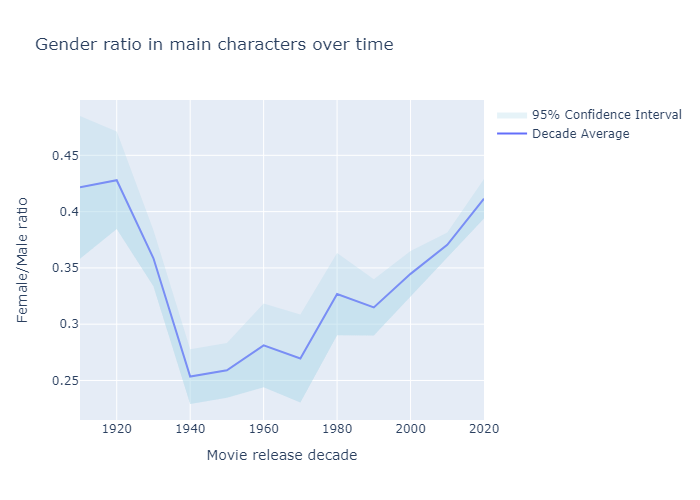

In [116]:
plot_gender_ratio_plotly(movie_data, folder=plot_folder)

We observe an initial decrease in female main character until the 1940s. From 1940 to 1990 the confidence intervals are quite large and we can thus not know for sure if the ratio increased or stayed stable. From the 1990s up till now, we see an increase of women main characters. However, again due to the size of the confidence interval, it's hard to state whether this increase started in the 90s or in the following years. We will nonetheless look at whether some events in the 1980s could have prompted an increase in women main characters.

In [117]:
for idx in timeline[(timeline['Date']>=1980)&(timeline['Date']<1990)].index:
    print(f'{timeline.Date[idx]} : {timeline.Event[idx]}')

1981 :  Sandra Day O’Connor is sworn in by President Ronald Reagan as the first woman to serve on the U.S. Supreme Court. She retires in 2006, after serving for 24 years.
1983 :  Flying on the Space Shuttle Challenger, Sally Ride becomes the first American woman in space.
1984 :  Democratic presidential nominee Walter Mondale names U.S. Rep. Geraldine Ferraro (N.Y.) as his running mate, making her the first woman vice president nominee by a major party.


We see here that in the 1980s we had the first woman on the supreme court as well as the first woman vice president nominee. We thus see women accessing to political positions that were so far only occupied by men. Moreover, this decade saw the first American into space. Seeing women accessing jobs that previously seemed out of reach may have impacted society. Therefore, as Hollywood picks up on these cues and wanting to reflect the advancement of mentalities, it portrayed more women in main character roles.

Our method does however present limitations:
1) Most mentioned characters does not necessarily mean "main" character.
2) We do not detect characters that are not mentioned by name (e.g. "teacher", "general").
3) We miss some characters for which the name in the text is not similar enough to the official name.
4) We only observe the first 5 sentences of each summary.

# 4) Clustering
<a id='section-4'></a>
The idea is to create a dataframe for each movie with the characteristics extracted from the data that could make them more or less stereotypical, namely:
- proportion of women in the movie
- female/male ratio of main character
- difference between mean age of men and of women

The clustering algorithm should thus group movies together that have similar level of gender stereotypes. We can then analyse the movies in these clusters to see if movie some genres, decades or popularity scores are more present in stereotypical movies. We can also analyse how the number of stereotypical movies evolve throughout the decades.

In [118]:
# remove character with unknown genders
character_data = character_data.dropna(subset='actor_gender')

## 4.1. Creating Clustering Data
<a id='subsection-4.1'></a>

### A) Proportion of female actress

In [119]:
# compute proportion of female actress per movie
characters_per_movie = character_data.groupby('IMDB_ID')
proportion_female = characters_per_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))

In [120]:
# create a dataframe on which we will perform clustering
stereotype_df = pd.DataFrame({'IMDB_ID': proportion_female.index,
                              'proportion_female': proportion_female.values})

### B) Proportion of female main character

In [121]:
movie_data = movie_data.dropna(subset='main character genders')
# compute the proportion of female main character for each movie
main_characters_ratio = \
    movie_data['main character genders'].apply(calculate_gender_ratio)
movie_data['proportion_female_main_char'] = main_characters_ratio

In [122]:
# merge with clustering dataframe and keep only movies with known main character proportions
stereotype_df = pd.merge(stereotype_df, movie_data[['IMDB_ID', 'proportion_female_main_char', 'decade']],
                         on='IMDB_ID', how='left')
stereotype_df = stereotype_df.dropna(subset='proportion_female_main_char')

In [123]:
stereotype_df

,IMDB_ID,proportion_female,proportion_female_main_char,decade
12,tt0002143,0.800000,0.0,1910.0
52,tt0002509,0.600000,0.5,1910.0
66,tt0002618,0.166667,0.666667,1910.0
70,tt0002663,0.250000,0.5,1910.0
80,tt0002755,0.444444,0.0,1910.0
...,...,...,...,...
46921,tt9907782,0.500000,0.0,2020.0
46922,tt9908448,0.600000,1.0,2010.0
46923,tt9908592,0.666667,0.0,2010.0
46927,tt9913288,0.000000,0.0,2020.0


### C) Age difference
Here we compute the difference of the mean age between men and women. This is added to the clustering data set since movies with much older men than women could be considered as more stereotypical. A negative value in the difference of means indicates that men are older than women.

In [124]:
mean_ages = compute_difference_mean_ages(character_data)
stereotype_df = pd.merge(stereotype_df, mean_ages[['IMDB_ID', 'difference_mean_ages']],
                         on='IMDB_ID', how='left')
stereotype_df = stereotype_df.dropna(subset='difference_mean_ages')
stereotype_df

,IMDB_ID,proportion_female,proportion_female_main_char,decade,difference_mean_ages
0,tt0002143,0.800000,0.0,1910.0,-8.000000
1,tt0002509,0.600000,0.5,1910.0,-0.333333
2,tt0002618,0.166667,0.666667,1910.0,-7.400000
3,tt0002663,0.250000,0.5,1910.0,-8.333333
4,tt0002755,0.444444,0.0,1910.0,-9.050000
...,...,...,...,...,...
12491,tt9898858,0.500000,0.333333,2020.0,-4.000000
12492,tt9899726,0.500000,1.0,2010.0,-21.000000
12495,tt9904648,0.500000,0.333333,2020.0,-3.000000
12496,tt9907782,0.500000,0.0,2020.0,-9.500000


## 4.2 K-means Clustering
<a id='subsection-4.2'></a>
Before doing the clustering, we need to pre-process the data. Proportions of female and of female main character are already normalised. We thus only need to normalise the age difference. We also identify the optimal number of clusters.

In [125]:
# prepare the data for clustering
clustering_df = stereotype_df.drop(columns=['IMDB_ID', 'decade'])
clustering_df['difference_mean_ages'] = \
    MinMaxScaler().fit_transform(clustering_df['difference_mean_ages'].values.reshape(-1, 1))

To find the optimal value of k for the clustering, we plot the sum squared error (sse) of the clustering for different k. The graph should show an "elbow", i.e. a k for which further increasing k does not lead to a decrease as important as before of the sse.

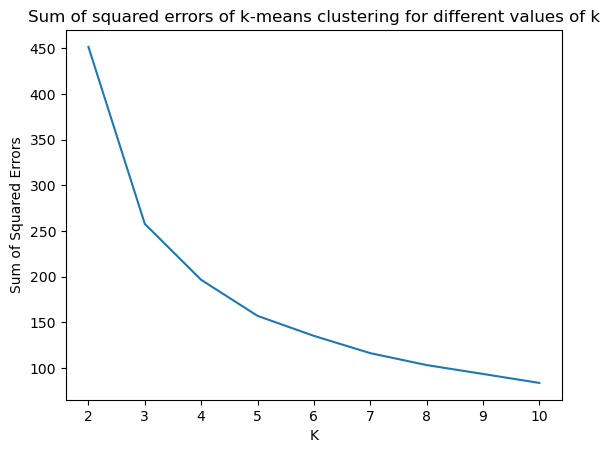

In [126]:
plot_sse(clustering_df)

We see on the plot above that the elbow of the curve is located at n=3. However, one could also see a second elbow at k=5. We will thus perform a second analysis to determine the appropriate k. We will choose the k with the highest silhouette score.

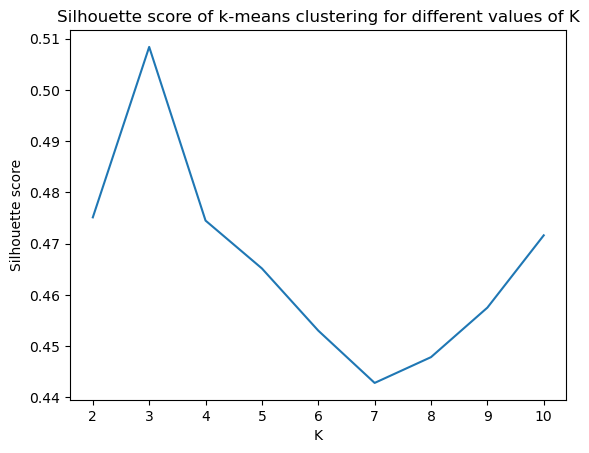

In [127]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10, n_init=10).fit_predict(clustering_df)
    # Get the Silhouette score
    score = silhouette_score(clustering_df, labels)
    silhouettes.append({"k": k, "score": score})

# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.title('Silhouette score of k-means clustering for different values of K')
plt.show()

We see on the plot above that the K with the highest silhouette score is 3. This confirmed what we observed using the elbow method and we will thus perform k-means clustering with k=3.

In [128]:
# run k-means
kmean = KMeans(n_clusters=3, random_state=0, n_init=10).fit(clustering_df)

### Visualising the clusters

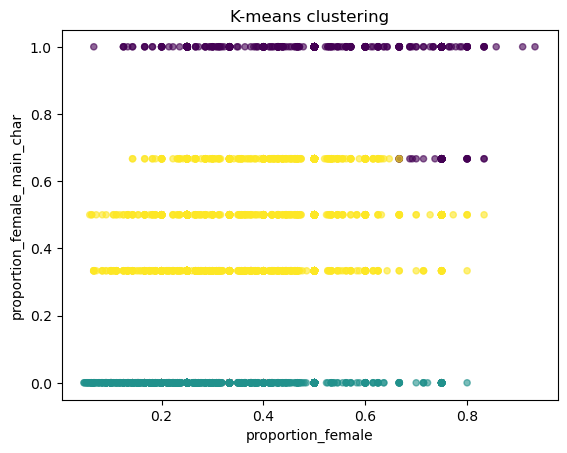

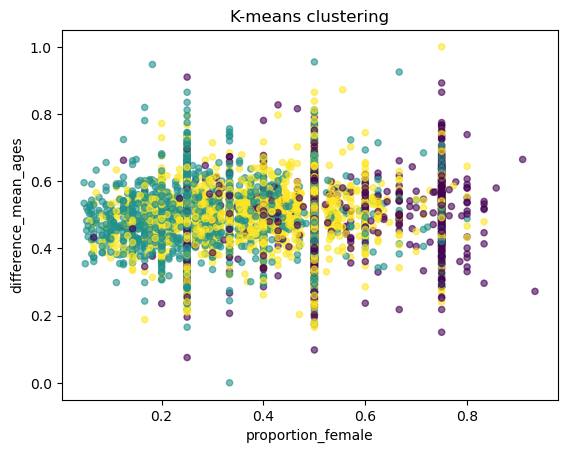

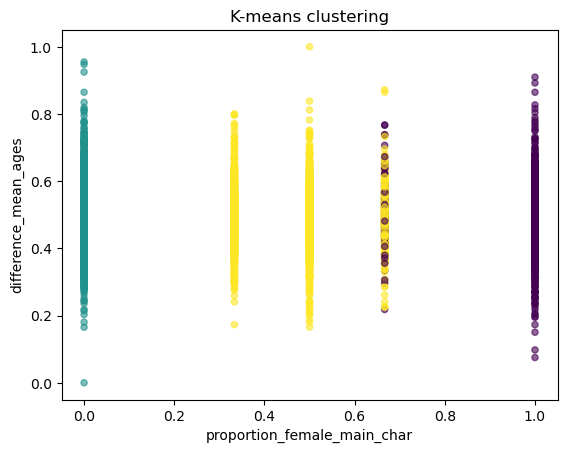

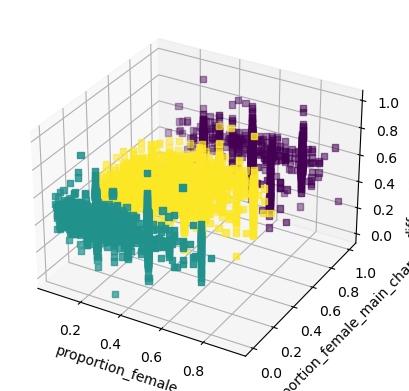

In [129]:
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female', 'proportion_female_main_char'])
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female', 'difference_mean_ages'])
plot_kmeans_2d(clustering_df, kmean.labels_, ['proportion_female_main_char', 'difference_mean_ages'])
plot_kmeans_3d(clustering_df, kmean.labels_,
               ['proportion_female', 'proportion_female_main_char', 'difference_mean_ages'])

## 4.3 Analysis of the Clusters
<a id='subsection-4.3'></a>

We will first look at the movies in each clusters to see if they were indeed clustered according to which extant they have a stereotypical depiction of women.

In [130]:
# add k-means label to the dataset that also contains IMDB IDs
stereotype_df['cluster_index'] = kmean.labels_
stereotype_df.drop(columns=['IMDB_ID', 'decade']).groupby('cluster_index').mean()

,proportion_female,proportion_female_main_char,difference_mean_ages
cluster_index,,,
0,0.531609,0.977797,-6.755061
1,0.321196,0.0,-8.079249
2,0.398346,0.461334,-7.196680


We see that cluster 0 seems to be the less stereotypical with a higher proportion of women in the cast and as main character and a smaller difference of means than the other clusters. Cluster 1 seems to be the most stereotypical. Indeed, we observe that movies in this cluster never have women as main characters and that they have a low proportion of actresses. Additionally, the difference of age between women and men is also higher than for movies in the other clusters. Cluster 2 seems to be located in between clusters 0 and 1 with a moderate amount of actresses both in general and playing main characters and an age difference bigger than cluster 0 but smaller than cluster 1. Since in the current analysis we are mostly interested in extremes (stereotypical and non-stereotypical movies), we will discard cluster 2 and focus on cluster 0 and 1.

In [131]:
# select most and least stereotypical movies according to the clustering
not_stereotypical_ids = stereotype_df[(stereotype_df['cluster_index'] == 0)]['IMDB_ID']
not_stereotypical_movies = movie_data[movie_data['IMDB_ID'].isin(not_stereotypical_ids)]
stereotypical_ids = stereotype_df[(stereotype_df['cluster_index'] == 1)]['IMDB_ID']
stereotypical_movies = movie_data[movie_data['IMDB_ID'].isin(stereotypical_ids)]

### A) Number of movies
As a first analysis we will have a look at the percentage of movies that belong to each category

In [132]:
not_stereo_percent = not_stereotypical_movies.shape[0]*100/stereotype_df.shape[0]
stereo_percent = stereotypical_movies.shape[0]*100/stereotype_df.shape[0]
print(f'{not_stereo_percent:.2f}% of movies do not represent women in a stereotypical way')
print(f'{stereo_percent:.2f}% of movies represent women in a stereotypical way')
print(f'{100-not_stereo_percent-stereo_percent:.2f}% were not classified into one of these categories')

16.74% of movies do not represent women in a stereotypical way
37.21% of movies represent women in a stereotypical way
46.05% were not classified into one of these categories


We see already that movies that clearly represent women in a non-stereotypical ways are in minority. Of course these percentages are computed on only a subset of our movies for which we were able to compute all the variables necessary for the clustering, but here we make the assumption that this subset is representative of the whole set of US movies.

### B) Popularity
Now we will analyse whether more popular movies tend to be more or less stereotypical. We can do this by using a t-test on the distribution of popularity for both datasets. The null hypothesis is "stereotypical and non-stereotypical movies have the same average popularity".

In [133]:
ttest_results = stats.ttest_ind(stereotypical_movies['popularity'].dropna(),
                                not_stereotypical_movies['popularity'].dropna())
print(f't-statistics = {ttest_results.statistic}, p value = {ttest_results.pvalue}')

t-statistics = 1.2158898915315504, p value = 0.22444449661983146


The p-value is higher than 0.05. We thus cannot reject the null hypothesis and make any conclusions. This might be due to the fact that we have very little data on the popularity of movies and would need more to make any meaningful conclusions.

### C) Genres
The aim of this part is to explore which genre stereotypical and non-stereotypical movies belong to. We will start by looking at the genres present in our two categories of movies.

In [134]:
not_stereotypical_genre_counts = not_stereotypical_movies['genre'].explode().value_counts()
stereotypical_genre_counts = stereotypical_movies['genre'].explode().value_counts()

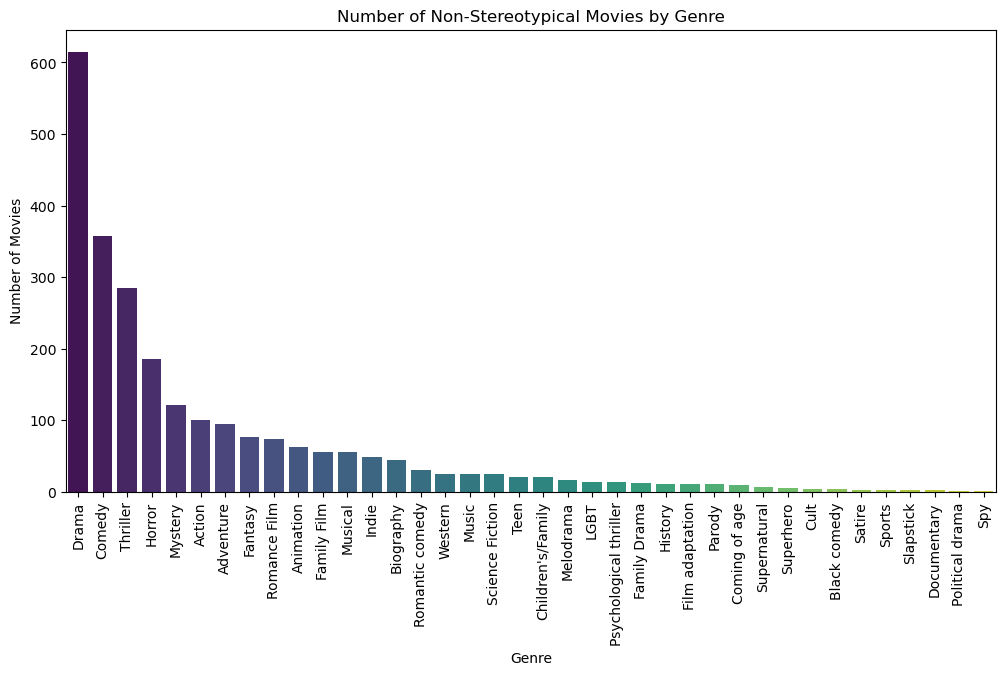

In [135]:
plt.figure(figsize=(12, 6))
sns.barplot(x=not_stereotypical_genre_counts.index,
            y=not_stereotypical_genre_counts.values, palette='viridis')
plt.title('Number of Non-Stereotypical Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

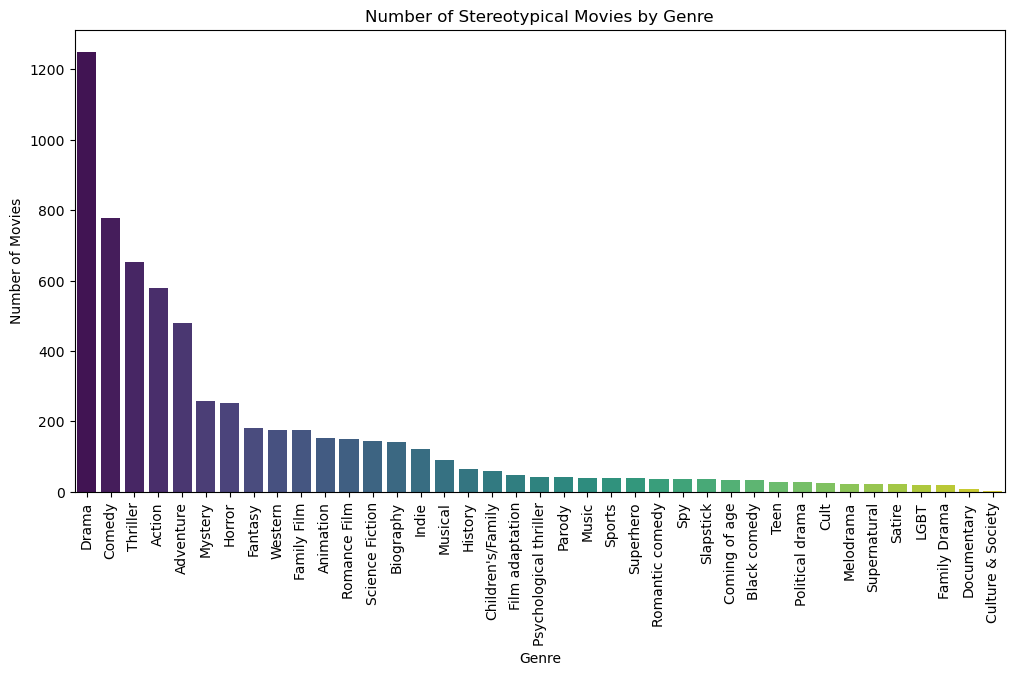

In [136]:
plt.figure(figsize=(12, 6))
sns.barplot(x=stereotypical_genre_counts.index,
            y=stereotypical_genre_counts.values, palette='viridis')
plt.title('Number of Stereotypical Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()

We see that a variety of genres are present in the two categories. Let's see how different the proportions of genre in each category is. Since the number of movies is different for stereotypical and non-stereotypical movies, we first normalise by the total number of movies for each category and then study the difference of this ratio.

In [137]:
# let's have a look at the difference
# first transform counts into percentages
percentage_stereo = stereotypical_genre_counts/stereotypical_movies.shape[0]
percentage_not_stereo = not_stereotypical_genre_counts/not_stereotypical_movies.shape[0]
# do the difference
percentage_diff = percentage_not_stereo - percentage_stereo
# if one genre is not present in one of the 2 categories we set its percentage to 0 in this category instead of nan
for genre in percentage_diff[percentage_diff.isna()].index:
    if stereotypical_genre_counts[genre] !=0:
        percentage_diff[genre] = -stereotypical_genre_counts[genre]/stereotypical_movies.shape[0]
    elif not_stereotypical_genre_counts[genre] != 0:
        percentage_diff[genre] = not_stereotypical_genre_counts[genre]/not_stereotypical_movies.shape[0]

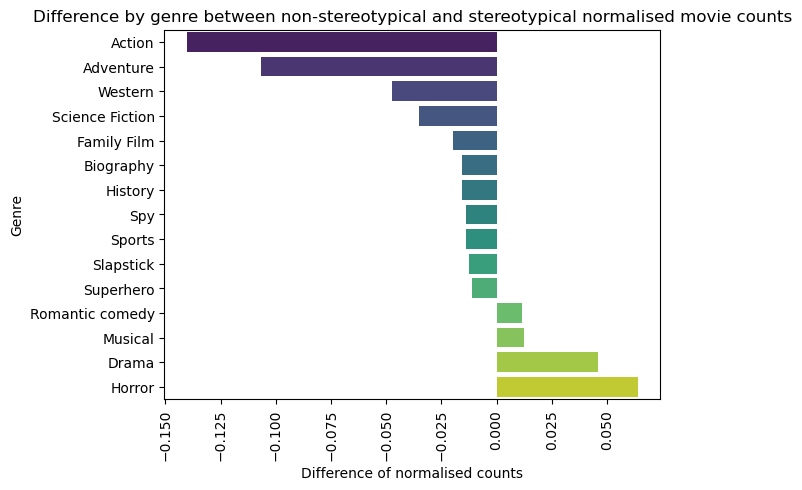

In [138]:
# sort in increasing order to plot
percentage_diff = percentage_diff.sort_values()
# only keep genres that have at least 1% difference between the 2 categories
percentage_diff_to_plot = \
    percentage_diff[(percentage_diff.values > 0.01) | (percentage_diff.values < -0.01)]
# plot
sns.barplot(x=percentage_diff_to_plot, y=percentage_diff_to_plot.index ,
            palette='viridis', orient='h')
plt.xticks(rotation=90)
plt.title('Difference by genre between non-stereotypical and stereotypical normalised movie counts')
plt.xlabel('Difference of normalised counts')
plt.ylabel('Genre')
plt.show()

The plot above represents the difference of ratio between the not stereotypical and the stereotypical movies. If the difference is negative it means that there is a higher proportion of this movie genre in the stereotypical movies. Inversely, if the difference is positive, it means that there is a higher proportion of this movie genre in the non-stereotypical movies. We thresholded the graph to only see movies that had a difference bigger than 0.01. We assumed that a smaller difference was too small to assume a real difference between the clusters.

Action movies are the ones that have the most difference between our two categories. The proportion of action movies in our stereotypical category is ~14% more than the one in our non-stereotypical category. We see that there are quite a few other categories that have a difference of proportion of more than 1%. The top 5 genre that appear more in the stereotypical movies are:
1. Action
2. Adventure
3. Western
4. Science Fiction
5. Family Film

Interestingly, we have less movie genres that are more present in the non-stereotypical group than in the other. We have only the 4 following categories:
1. Horror
2. Drama
3. Musical
4. Romantic comedy

Here we see one caveat of our method. Indeed, romantic comedies appear in the movies that have a non-stereotypical representation of women. It is however well-known that in general in romantic comedies women are solely love interests and are thus portrayed stereotypically. This highlights the need to not only look at the proportion of actress, the proportion of women character and the age difference but consider other factors. More precisely it would be interesting to look at the vocabulary linked to female and male actress in general and also in these specific genres to see if they really are less stereotypical.

Another thing that is important to note is that here we took the data across all years. Since we have much more movies in the decades 2010-2020, these years are overrepresented in the previous analysis.

### D) Decades
After these first analyses, we will now look at how the the stereotypical and not stereotypical movies evolve through the decades.

Let's first simply have a look at whether the distribution of decades throughout the stereotypical and not stereotypical datasets differ. To do so, we perform a t-test with the null hypothesis "stereotypical movies have the same mean release decade as non-stereotypical ones".

In [139]:
ttest_results = stats.ttest_ind(stereotypical_movies['decade'].dropna(),
                                not_stereotypical_movies['decade'].dropna())
print(f't-statistics = {ttest_results.statistic}, p value = {ttest_results.pvalue}')

t-statistics = -7.045176023921748, p value = 2.2015444435497535e-12


The results of the t-test indicate that we can reject the null hypothesis at a significance level of 0.05. We can thus conclude that there is a difference in mean release decade between stereotypical and non-stereotypical movies. Moreover, since the t-statistics is negative, we can conclude that stereotypical movies tend to have been release in earlier decades than non-stereotypical movies. This is coherent with our original hypothesis that was that as women's rights progresses, their representation in the cinema industry evolves to be less biased.

To further explore the link between the decades and the extent of gender representation in movies, we will have a look at the proportion of movies released that had a stereotypical representation of women per decade.

In [140]:
# Group movies by decade
stereo_movie_by_decade = stereotypical_movies.groupby(stereotypical_movies['decade'])
not_stereo_movie_by_decade = not_stereotypical_movies.groupby(not_stereotypical_movies['decade'])
total_movies = movie_data[movie_data['IMDB_ID'].isin(stereotype_df['IMDB_ID'])]
total_movies_per_year = total_movies.groupby(total_movies['decade'])

# compute fraction of total movies per decade for each category
fraction_stereo_movies_decade = stereo_movie_by_decade.size()/total_movies_per_year.size()
fraction_not_stereo_movies_decade = not_stereo_movie_by_decade.size()/total_movies_per_year.size()
others = 1-fraction_not_stereo_movies_decade-fraction_stereo_movies_decade

# compute confidence interval using bootstrap
lower_stereo, upper_stereo, lower_not_stereo, upper_not_stereo = \
    bootstrap_ci_stereotypical_movies(stereotype_df)

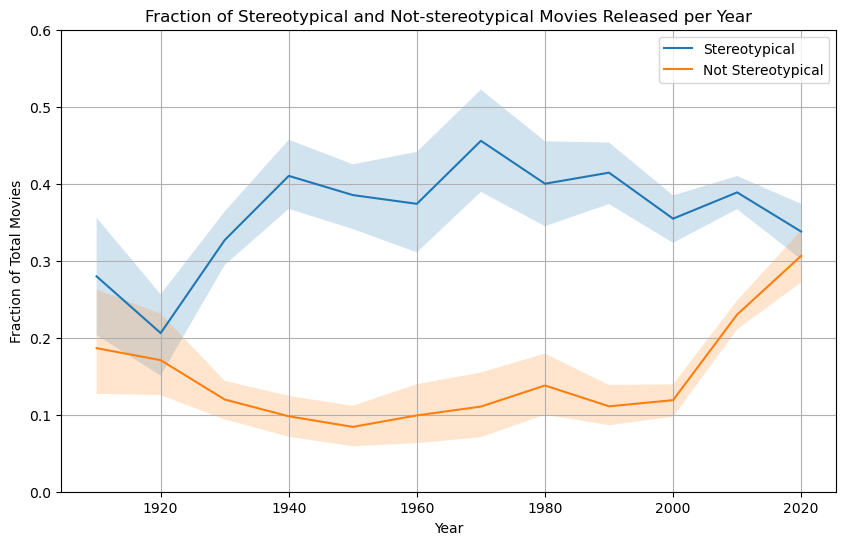

In [141]:
# Plot

plt.figure(figsize=(10, 6))
fraction_stereo_movies_decade.plot(kind='line', label='Stereotypical')
fraction_not_stereo_movies_decade.plot(kind='line', label='Not Stereotypical')

plt.fill_between(fraction_stereo_movies_decade.index,
                 lower_stereo, upper_stereo, alpha=0.2)
plt.fill_between(fraction_not_stereo_movies_decade.index,
                 lower_not_stereo, upper_not_stereo, alpha=0.2)

plt.title('Fraction of Stereotypical and Not-stereotypical Movies Released per Year')
plt.xlabel('Year')
plt.ylabel('Fraction of Total Movies')
plt.legend()
plt.grid(True)
plt.ylim(0,0.6)
plt.show()

We see that before 1920 the confidence interval intercepts and we thus cannot reach any conclusions. However, we see that from 1920 up to 2020 there seem to always have been a bigger percentage of movies produced that had a stereotypical depiction of women. From 1920 to 1940 we see an increase in the stereotypical movies produced. In the 70s the proportion of stereotypical movies was almost 50% and is the highest in the years analysed. However, it is important to note that the confidence intervals are quite big, we thus cannot be sure that the trend observed from 1940 to 2020 is accurate and the number of stereotypical movies during this period could also just have stayed the same.

Interestingly, the proportion of non-stereotypical movies was relatively stable throughout the decades until 2000. From 2000 to 2020 we see a strong increase of the proportion of movies with a non-stereotypical depiction of women to reach approximately the same percentage than stereotypical movies.

In conclusion, we can see that the depiction of women evolved through time. Indeed, even though the proportion of stereotypical movies increased in the early 20th century and then stayed at a relatively high level, the proportion of movies having representation of women going against stereotypes increased drastically from 2000 to 2020.

Finally, we will try to see whether any of these could be explained by the events in our timeline.

Let's see which events could have prompted the increase of non-stereotypical movies in 2000 and later. Since movies take a lot of time to be made, we can assume that events from the 1990s and later could influence this increase and that events after 2018 (5 years ago) did not have enough time to really affect the cinema industry yet.

In [142]:
for idx in timeline[(timeline['Date']>=1990)&(timeline['Date']<2018)].index:
    print(f'{timeline.Date[idx]} : {timeline.Event[idx]}')

1993 :  Nominated by President Bill Clinton, Janet Reno is sworn in as the first female attorney general of the United States.
1997 :  Also nominated by Clinton, Madeleine Albright is sworn in as the nation’s first female secretary of state.
1994 :  Clinton signs the Violence Against Women Act as part of the Violent Crime Control and Law Enforcement Act, providing funding for programs that help victims of domestic violence, rape, sexual assault, stalking and other gender-related violence.
2007 :  U.S. Rep. Nancy Pelosi (D-Calif.) becomes the first female speaker of the House. In 2019, she reclaims the title, becoming the first lawmaker to hold the office two times in more than 50 years. 
2013 :  The U.S. military removes a ban against women serving in combat positions.
2016 :  Hillary Clinton becomes the first woman to receive a presidential nomination from a major political party. During her speech at the Democratic National Convention, she says, “Standing here as my mother's daughter

We see that we have multiple events where women acceded to a position of power (first female attorney, first female secretary of state, first female speaker of the house). This could have shaped the vision of women in the US and prompted movies to be made with more women as main and supporting characters.

To conclude, the trend observed for stereotypical movie cannot be confirmed due to the size of the confidence intervals. Most importantly, the increase of non-stereotypical movies in the past 20 years coincide well with the increase of women in position of power in the US. Of course, we cannot state that this increase is due to these specific events and that probably a lot of other factor influenced this. It is however still an interesting link to make.

# 5) Associated words analysis
<a id='section-5'></a>

## 5.1 Data selection for associated words analysis
<a id='subsection-5.1'></a>

In [143]:
personas_data = pickle.load(open("pickles/characters_personas_data.pickle", "rb")) # SHOULD BE IN FOLDER PICKLE SO TO MODIFY!

FileNotFoundError: [Errno 2] No such file or directory: 'pickles/characters_personas_data.pickle'

In [ ]:
display(personas_data)

In [ ]:
# we drop the characters that have no words associated to them -  they do not appear in summaries
personas_noNA = personas_data.dropna(subset="Chunks")
display(personas_noNA)

In [ ]:
# create a column "decade" to do the analysis on decades and not years
final_personas_df = personas_noNA.copy()
final_personas_df['decade'] = final_personas_df['release_date'] // 10 * 10
display(final_personas_df)

In [ ]:
movie_data = pickle.load(open("pickles/movie_data_final.pickle", "rb")) # SHOULD BE IN FOLDER PICKLE SO TO MODIFY!
movie_data

In [ ]:
final_personas_df = final_personas_df.merge(movie_data[['IMDB_ID', 'genre']], on='IMDB_ID', how='left')
# sort the rows to have decades in ascending orders
final_personas_df = final_personas_df.sort_values(by='decade')
final_personas_df

In [ ]:
unique_decades = final_personas_df['decade'].unique() # control the order of the decades
print(unique_decades)

In [ ]:
# group the movies by decade
personas_by_decade = final_personas_df.groupby(final_personas_df['decade'])
count_per_decade = personas_by_decade.size() # to have the number of characters per decade

plt.figure(figsize=(10, 6))
count_per_decade.plot(kind='line', color='skyblue', marker='o')
plt.title('Number of Character per Decade in the Dataset')
plt.xlabel('Decade')
plt.ylabel('Number of Characters')
plt.grid(True)
plt.show()

There is a fairly huge number of character per decade from 1930 onwards so the later analysis should be reliable. However, the number of characters in the 1910s' as well as 1920s' is low so these 2 decades might not have results that accurately represent reality.

By quickly looking at the verbs, we can see that the same verb appears several times but with different conjugation (e.g.: kill, kills, killing, killed). Thus, to groupe these same words together later in the analysis, we apply stemming on the column Verbs. We do not perform stemming on Adjectives and Nouns as there is no problem of conjugation. There could be problems with singular and plural but we think this issue is minimal so we ignore it.

In [ ]:
tqdm.pandas(desc='Stemming')
final_personas_df['Verbs'] = final_personas_df['Verbs'].progress_apply(stem_words_with_progress)
display(final_personas_df)

## 5.2 Analysis of words associated to each gender: which terms are stereotypical?
<a id='subsection-5.2'></a>

In [ ]:
male_dict, female_dict = create_gender_dictionaries(final_personas_df)

In [ ]:
male_frequencies_per_decade = calculate_word_frequencies(male_dict)
female_frequencies_per_decade = calculate_word_frequencies(female_dict)

In [ ]:
relative_frequencies, unique_male, unique_female = subtract_frequencies(male_frequencies_per_decade, female_frequencies_per_decade)

In [ ]:
total_words = 0
for decade, categories in relative_frequencies.items():
    for category, words in categories.items():
        total_words += len(words)

total_words_M = 0
for decade, categories in unique_male.items():
    for category, words in categories.items():
        total_words_M += len(words)

total_words_F = 0
for decade, categories in unique_female.items():
    for category, words in categories.items():
        total_words_F += len(words)

print("The total number of words is:", total_words)
print(total_words_M, " words are solely associated to men, representing ",100*total_words_M/total_words, "% of the total number of words")
print(total_words_F, " words are solely associated to women, representing ",100*total_words_F/total_words, "% of the total number of words")

In [ ]:
categories_to_plot = ['Verbs', 'Adjectives', 'Nouns']
plot_rel_freq_per_decade(relative_frequencies, categories_to_plot)

## Analysis
These plots show the top 5 associated verbs, nouns and adjectives for men and women respectively. We can see the following elements:
- The words associated for each gender are overall quite constant throughout the decades. Additionnaly the words typically associated for each gender fall into similar lexical categories.
    - For men the typical words are highly action related with words such as kill, save or soldier
    - For women the typical words are more related to everyday life with words such as love, marry or family or to their appearance with words such as beautiful or pretty
- We also see that the word man (or men) and woman (or women) is typically associated with their associated gender . This functions as a control and show that the method used works as expected.

In conclusion we can see that when looking at all movies the words most associated with each gender corresponds to the common societal stereotypes associated to each gender. This event is insentive to time. This shows us that the most common traits for men and women in movies has stayed constant throughout the years. However this series of graphs does not give us any indications on the evolution of more subtle traits.

In [ ]:
categories_to_plot = ['Verbs', 'Adjectives', 'Nouns']
plot_top_words_per_decade(unique_male, categories_to_plot, "skyblue")

In [ ]:
plot_top_words_per_decade(unique_female, categories_to_plot, "pink")

## 5.3 Associated words analysis per gender per movie genre
<a id='subsection-5.3'></a>

First, let's check the number of characters in each of these genres.